To-Do: clarify positives & negatives of confusion matrix

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import confusion_matrix

## Logistic Regression

### GME

In [3]:
# Imports
gme_wr_v = pd.read_csv('./gme_weekly_return_volatility.csv')
# Mask weekly return by year.  Labels already for 2020, 2021
gme_wr_v = gme_wr_v[np.isin(gme_wr_v.Year.values,[2020,2021])]
gme_wr_v['Labels'] = pd.read_csv('./gme_labels.csv', header=None)[0].values

In [4]:
X = gme_wr_v[['mean_return','volatility']].values
y = gme_wr_v[['Labels']].values
le = LabelEncoder() 
y = le.fit_transform(np.ravel(y))
y = 1 - y # make 'Green' 1, 'Red' 0
m_2020 = np.array(gme_wr_v.Year == 2020) # make masks for train, test
m_2021 = np.array(gme_wr_v.Year == 2021)
(X_tr, y_tr) = (X[m_2020], y[m_2020])
(X_te, y_te) = (X[m_2021], y[m_2021])

scaler = StandardScaler()
scaler.fit(X_tr)

(X_tr, X_te) = (scaler.transform(X_tr), scaler.transform(X_te))

In [5]:
lr = LogisticRegression()

In [6]:
lr.fit(X_tr,y_tr)

LogisticRegression()

In [7]:
coefs = np.array(lr.coef_.flat)
lr.coef_[0]

array([2.23529302, 0.34453957])

In [8]:
np.e**lr.coef_

array([[9.34922099, 1.41133994]])

For a one unit increase in mean_return, the odds of being a green label increase by 834.9% or a factor of 9.349, while for every increase of one in volatility,  the odds of a "Green" label increase by 41.13% or a factor of 1.411

In [9]:
np.e**lr.intercept_

array([1.47711064])

The odds of a week with volatility of zero and mean return of zero being a 'green' week is 1.477 to 1.

In [10]:
i = lr.intercept_[0]
w_mr = coefs[0]
w_v = coefs[1]

In [11]:
print(f'In the equation for the log odds, the intercept is {i:.2f}, \
the coefficient for mean_return is {w_mr:.2f}, \
and the coefficient for volatility is {w_v:.2f}')

In the equation for the log odds, the intercept is 0.39, the coefficient for mean_return is 2.24, and the coefficient for volatility is 0.34


###### Q2 Year 2 accuracy

In [12]:
y_pr = lr.predict(X_te)

In [13]:
accuracy = lr.score(X_te,y_te)
print(f'accuracy: {accuracy:.2%}')

accuracy: 82.69%


In [14]:
confusion_matrix(y_te,y_pr)

array([[26,  8],
       [ 1, 17]])

In [15]:
cm = confusion_matrix(y_te,y_pr)

In [16]:
# true ones are true 'Green', true zeros are true 'Red'
tpr = cm[1,1]/sum(cm[1,:]) # TP / (TP + FN)
tnr = cm[0,0]/sum(cm[0,:]) # TN / (TN + FP)

In [17]:
print(f'the tpr is {tpr:.2f} and the tnr is {tnr:.2f}')

the tpr is 0.94 and the tnr is 0.76


In [18]:
gme_wr_v[gme_wr_v.Year == 2021].mean_return.values

array([-1.145200e+00,  1.724280e+01,  1.783475e+01,  5.384920e+01,
       -2.220020e+01, -3.588800e+00, -6.100000e+00,  2.543100e+01,
        6.445200e+00,  1.506480e+01, -5.199200e+00,  1.594200e+00,
        1.474500e+00, -3.704200e+00, -8.000000e-03, -3.864000e-01,
        2.923200e+00, -1.444800e+00,  1.716000e-01,  2.219000e+00,
        5.222200e+00,  3.295500e+00, -1.092000e-01, -1.715400e+00,
       -2.596000e-01, -6.192000e-01, -1.443000e+00, -2.389200e+00,
        1.423800e+00, -2.203000e+00, -1.144400e+00,  1.411800e+00,
       -3.588000e-01,  5.728200e+00, -1.612000e-01, -1.540750e+00,
        1.530800e+00, -1.980200e+00, -8.690000e-01, -4.728000e-01,
        1.224400e+00, -1.476600e+00,  1.598000e+00,  3.126200e+00,
       -1.015600e+00,  2.570800e+00, -3.021000e+00, -2.832400e+00,
       -1.443000e+00, -9.220000e-02, -5.565000e-01,  5.615000e-01])

In [19]:
def cum_return_factor(return_weeks):
    return_factors = (return_weeks)
    total_return_factor = np.prod(return_factors)
    return total_return_factor

In [20]:
gme=pd.read_csv('./gme.csv')

In [21]:
this_wk_last_wk = dict(zip(gme.Year_Week.unique()[1:], 
                           gme.Year_Week.unique()[:-1]))

In [22]:
def trade_from_close_close(stock,sd):
    '''Args: stock: dataframe of stock data | sd: dictionary of staggered weeks,
    i.e. {2017-02:2017-01, ... 2021-52:2021-51} for gettin prior week adjusted
    close Return a dataframe with weekly return factors based on first day of week
    open and last day of week close.'''
    
    stock_by_week = pd.DataFrame(
        columns=['Year','Year_Week',"Begin_Price","Adj Close", 'Return'])
    
    year_weeks = stock["Year_Week"].unique()
    
    for inx, yw in enumerate(year_weeks):
        this_week = stock[stock["Year_Week"]==yw]
        try:
            begin_price = stock[stock["Year_Week"]==sd[yw]].\
            tail(1)['Adj Close'].values[0]
        except (IndexError,KeyError): 
            begin_price = this_week.head(1)['Open'].values[0]
        close_price = this_week.tail(1)['Adj Close'].values[0]
        r = close_price/begin_price
        y = this_week.tail(1)['Year'].values[0]
        stock_by_week.loc[inx,:] = [y,yw,begin_price,close_price,r]
    return stock_by_week

In [23]:
gme_returns = trade_from_close_close(gme,this_wk_last_wk)

In [24]:
gme_returns

,Year,Year_Week,Begin_Price,Adj Close,Return
0,2017,2017-01,6.36,4.99,0.784591
1,2017,2017-02,4.99,4.62,0.925852
2,2017,2017-03,4.62,4.79,1.036797
3,2017,2017-04,4.79,4.94,1.031315
4,2017,2017-05,4.94,5.03,1.018219
...,...,...,...,...,...
258,2021,2021-48,49.93,43.1,0.863208
259,2021,2021-49,43.1,39.75,0.922274
260,2021,2021-50,39.75,38.91,0.978868
261,2021,2021-51,38.91,38.03,0.977384


Note: 1 predictions are "red", so I need to invert the boolean mask to get 'green' predictions.

In [25]:
logreg_return = np.round(100*np.prod(\
    gme_returns[gme_returns.Year == 2021].Return.values[\
                                    np.ma.make_mask(y_pr,shrink=False)]),2)

In [26]:
buy_hold_return = np.round(100*
    gme_returns[gme_returns.Year == 2021]['Adj Close'].values[-1]/
    gme_returns[gme_returns.Year == 2021]['Begin_Price'].values[0])

In [27]:
print(f'$100 invested in GME at the beginning of 2021 would result in \
${logreg_return:,} by the end of 2021 if traded according to "green" \
predictions.  Admittedly, knowing return and volatility in advance is not \
possible in the real world.  The buy-and-hold strategy would have resuled in \
${buy_hold_return:,}')

$100 invested in GME at the beginning of 2021 would result in $44,369.46 by the end of 2021 if traded according to "green" predictions.  Admittedly, knowing return and volatility in advance is not possible in the real world.  The buy-and-hold strategy would have resuled in $824.0


### Spy logreg

In [28]:
spy_wr_v = pd.read_csv('./spy_weekly_return_volatility.csv')
spy_wr_v = spy_wr_v[np.isin(spy_wr_v.Year.values,[2020,2021])]
spy_wr_v['Labels'] = pd.read_csv('./spy_labels.csv', header=None)[0].values

In [29]:
X = spy_wr_v[['mean_return','volatility']].values
y = spy_wr_v[['Labels']].values
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)
y = le.fit_transform(np.ravel(y))
y = 1-y 
X_tr = X[spy_wr_v.Year == 2020]
y_tr = y[spy_wr_v.Year == 2020]
X_te = X[spy_wr_v.Year == 2021]
y_te = y[spy_wr_v.Year == 2021]

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)


In [30]:
le.classes_

array(['Green', 'Red'], dtype=object)

In [31]:
lr = LogisticRegression()

In [32]:
lr.fit(X_tr,y_tr)

LogisticRegression()

In [33]:
coef = np.array(lr.coef_.flat)

In [34]:
lr.intercept_

array([0.09981525])

In [35]:
i = lr.intercept_[0]
w_mr = coef[0]
w_v = coef[1]

In [36]:
print(f'In the equation for the log odds, the intercept is {i:.2f}, \
the coefficient for mean_return is {w_mr:.2f}, \
and the coefficient for volatility is {w_v:.2f}')

In the equation for the log odds, the intercept is 0.10, the coefficient for mean_return is 3.07, and the coefficient for volatility is -0.28


Intercept & coefficient interpretations:

In [37]:
np.e**coef

array([21.49293903,  0.75457811])

In [38]:
print(f'In the equation for the log odds, with mean return 0 and volatility 0, \
the odds of the week being labeled "Green" is {np.e**i -1:.2f} to one.  For every increase in\
 mean return of 1, the odds of a "Green" label increases by {np.e**w_mr -1:.2%}.\
 For every increase of one in volatility, the odds of a "Green" label increases\
 by {np.e**w_v-1:.2%}')

In the equation for the log odds, with mean return 0 and volatility 0, the odds of the week being labeled "Green" is 0.10 to one.  For every increase in mean return of 1, the odds of a "Green" label increases by 2049.29%. For every increase of one in volatility, the odds of a "Green" label increases by -24.54%


###### Q2 Year 2 accuracy

In [39]:
y_pr = lr.predict(X_te)

In [40]:
accuracy = lr.score(X_te,y_te)
print(f'accuracy: {accuracy:.2%}')

accuracy: 96.15%


In [41]:
confusion_matrix(y_te,y_pr)

array([[19,  2],
       [ 0, 31]])

In [42]:
cm = confusion_matrix(y_te,y_pr)

In [43]:
tpr = cm[1,1]/sum(cm[1,:])
tnr = cm[0,0]/sum(cm[0,:])

In [44]:
cm.view()

array([[19,  2],
       [ 0, 31]])

In [45]:
print(f'the tpr is {tpr:.2f} and the tnr is {tnr:.2f}')

the tpr is 1.00 and the tnr is 0.90


In [46]:
def cum_return_factor(return_weeks):
    return_factors = (return_weeks)
    total_return_factor = np.prod(return_factors)
    return total_return_factor

In [47]:
spy=pd.read_csv('./spy.csv')

In [48]:
this_wk_last_wk = dict(zip(spy.Year_Week.unique()[1:], 
                           spy.Year_Week.unique()[:-1]))

In [49]:
spy_returns = trade_from_close_close(spy,this_wk_last_wk)

Since Begin_price on day one here is so much higher than the first adjusted close.  Weeks two onwards use the prior week's adjusted close as the begin price and so don't have the same distortion.

In [50]:
logreg_return = np.round(100*np.prod(\
    spy_returns[spy_returns.Year == 2021].Return.values[\
                                    np.ma.make_mask(y_pr,shrink=False)]),2)

In [51]:
buy_hold_return = np.round(100*
    spy_returns[spy_returns.Year == 2021]['Adj Close'].values[-1]/
    spy_returns[spy_returns.Year == 2021]['Begin_Price'].values[0])

In [52]:
print(f'$100 invested in spy at the beginning of 2021 would result in \
${logreg_return:,} by the end of 2021 if traded according to "green" \
predictions.  Admittedly, knowing return and volatility in advance is not \
possible in the real world.  The buy-and-hold strategy would have resuled in \
${buy_hold_return:.2f}')

$100 invested in spy at the beginning of 2021 would result in $165.06 by the end of 2021 if traded according to "green" predictions.  Admittedly, knowing return and volatility in advance is not possible in the real world.  The buy-and-hold strategy would have resuled in $129.00


## KMeans

Implement k-NN classifier For each week, your feature set is
(µ, σ) for that week. Use your labels (you will have 52 labels
per year for each week) from year 1 to train your classifier and
predict labels for year 2.

### GME

In [53]:
gme_wr_v = pd.read_csv('./gme_weekly_return_volatility.csv')
gme_wr_v = gme_wr_v[np.isin(gme_wr_v.Year.values,[2020,2021])]
gme_wr_v['Labels'] = pd.read_csv('./gme_labels.csv', header=None)[0].values

In [54]:
X = gme_wr_v[['mean_return','volatility']].values
y = gme_wr_v[['Labels']].values
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)
y = 1- le.fit_transform(np.ravel(y))
X_tr = X[gme_wr_v.Year == 2020]
y_tr = y[gme_wr_v.Year == 2020]
X_te = X[gme_wr_v.Year == 2021]
y_te = y[gme_wr_v.Year == 2021]

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

###### Q1. take k = 3, 5, 7, 9, 11. For each value of k compute the accuracy of your k-NN classifier on year 1 data. On x axis you plot k and on y-axis you plot accuracy. What is the optimal value of k for year 1?

In [55]:
accuracies = []

In [56]:
for k in range(3,12,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr, y_tr)
    pred_k = knn.predict(X_tr)
    accuracies.append(np.mean(pred_k == y_tr))

In [57]:
accuracies

[0.9245283018867925,
 0.9245283018867925,
 0.9056603773584906,
 0.8679245283018868,
 0.8301886792452831]

Text(0, 0.5, 'Accuracy')

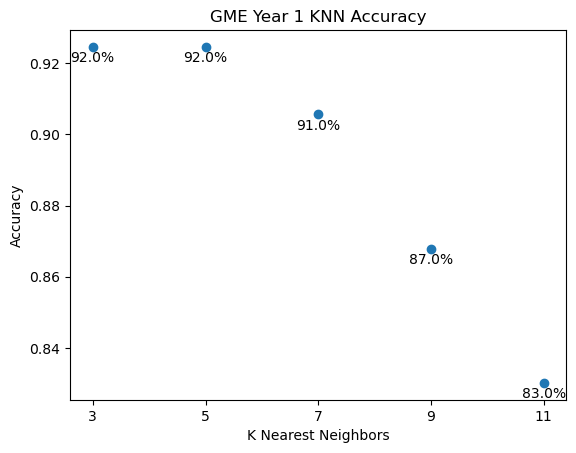

In [58]:
plt.scatter(x=range(3,12,2), y = accuracies)
for i, k in enumerate(range(3,12,2)):
    plt.annotate(text = f"{100*np.round(accuracies[i],2)}%",
             xy=(k,accuracies[i]),xytext=(-16,-11),
                textcoords='offset points')
plt.title("GME Year 1 KNN Accuracy")
plt.xticks(range(3,12,2))
plt.xlabel('K Nearest Neighbors')
plt.ylabel('Accuracy')

###### Q2. use the optimal value of k from year 1 to predict labels for year 2. What is your accuracy?

I'll use a k of 5, since k = 3 and k = 5 have the same y1 accuracy.

In [59]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr,y_tr)
pred_5 = knn.predict(X_te)
accuracy = np.mean(np.equal(pred_5,y_te))

In [60]:
np.round(accuracy,3)

0.865

The accuracy drops to 86.5% in y2 with the 5 neighbor knn classifier.

###### 3. using the optimal value for k from year 1, compute the confusion matrix for year 2

In [61]:
confusion_matrix(y_te, pred_5)

array([[28,  6],
       [ 1, 17]])

###### 4. what is true positive rate (sensitivity or recall) and true negative rate (specificity) for year 2?

True positive rate is 17/18, and the true negative rate is 28/34

5. implement a trading strategy based on your labels for year2 and compare the performance with the ”buy-and-hold” strategy. Which strategy results in a larger amount at the end of the year?

In [62]:
gme_returns = trade_from_close_close(gme,this_wk_last_wk)

In [63]:
knn_return = np.round(100*np.prod(\
    gme_returns[gme_returns.Year == 2021].Return.values[\
                                    ~np.ma.make_mask(pred_5,shrink=False)]),2)

In [64]:
buy_hold_return = np.round(100*
    gme_returns[gme_returns.Year == 2021]['Adj Close'].values[-1]/
    gme_returns[gme_returns.Year == 2021]['Begin_Price'].values[0])

In [65]:
print(f'$100 invested in gme at the beginning of 2021 would result in \
${knn_return:,} by the end of 2021 if traded according to "green" \
predictions.  Admittedly, knowing return and volatility in advance is not \
possible in the real world.  The buy-and-hold strategy would have resuled in \
${buy_hold_return:,}')

$100 invested in gme at the beginning of 2021 would result in $1.8 by the end of 2021 if traded according to "green" predictions.  Admittedly, knowing return and volatility in advance is not possible in the real world.  The buy-and-hold strategy would have resuled in $824.0


### SPY

In [66]:
X = spy_wr_v[['mean_return','volatility']].values
y = spy_wr_v[['Labels']].values
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)
y = le.fit_transform(np.ravel(y))
X_tr = X[spy_wr_v.Year == 2020]
y_tr = y[spy_wr_v.Year == 2020]
X_te = X[spy_wr_v.Year == 2021]
y_te = y[spy_wr_v.Year == 2021]

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

###### Q1. take k = 3, 5, 7, 9, 11. For each value of k compute the accuracy of your k-NN classifier on year 1 data. On x axis you plot k and on y-axis you plot accuracy. What is the optimal value of k for year 1?

In [67]:
accuracies = []

In [68]:
for k in range(3,18,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr, y_tr)
    pred_k = knn.predict(X_tr)
    accuracies.append(np.mean(pred_k == y_tr))

In [69]:
accuracies

[0.9811320754716981,
 0.9811320754716981,
 0.9811320754716981,
 0.9811320754716981,
 0.9811320754716981,
 0.9622641509433962,
 0.9245283018867925,
 0.9245283018867925]

Text(0, 0.5, 'Accuracy')

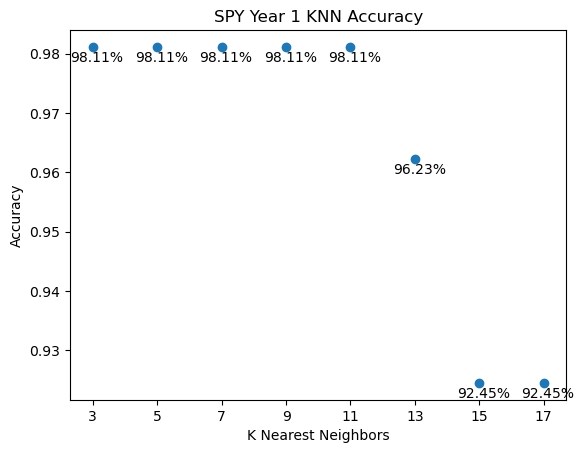

In [70]:
plt.scatter(x=range(3,18,2), y = accuracies)
for i, k in enumerate(range(3,18,2)):
    plt.annotate(text = f"{np.round(100*accuracies[i],2)}%",
             xy=(k,accuracies[i]),xytext=(-16,-11),
                textcoords='offset points')
plt.title("SPY Year 1 KNN Accuracy")
plt.xticks(range(3,18,2))
plt.xlabel('K Nearest Neighbors')
plt.ylabel('Accuracy')

K values up to 17 to investigate possible error determining accuracy of 98.11

###### Q2. use the optimal value of k from year 1 to predict labels for year 2. What is your accuracy?

I'll use a k of 5, since k = 3 and k = 5 have the same y1 accuracy.

In [71]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr,y_tr)
pred_5 = knn.predict(X_te)
accuracy = np.mean(np.equal(pred_5,y_te))

In [72]:
np.round(accuracy,3)

0.981

The accuracy drops to 98.1% in y2 with the 5 neighbor knn classifier.

###### 3. using the optimal value for k from year 1, compute the confusion matrix for year 2

In [73]:
confusion_matrix(y_te, pred_5)

array([[31,  0],
       [ 1, 20]])

###### 4. what is true positive rate (sensitivity or recall) and true negative rate (specificity) for year 2?

True positive rate is 20/21, and the true negative rate is 31/31.

5. implement a trading strategy based on your labels for year2 and compare the performance with the ”buy-and-hold” strategy. Which strategy results in a larger amount at the end of the year?

In [74]:
knn_return = np.round(100*np.prod(\
    spy_returns[spy_returns.Year == 2021].Return.values[\
                                    ~np.ma.make_mask(pred_5,shrink=False)]),2)

In [75]:
buy_hold_return = np.round(100*
    spy_returns[spy_returns.Year == 2021]['Adj Close'].values[-1]/
    spy_returns[spy_returns.Year == 2021]['Begin_Price'].values[0])

In [76]:
print(f'$100 invested in spy at the beginning of 2021 would result in \
${knn_return:,} by the end of 2021 if traded according to "green" \
predictions.  Admittedly, knowing return and volatility in advance is not \
possible in the real world.  The buy-and-hold strategy would have resulted in \
${buy_hold_return:,}')

$100 invested in spy at the beginning of 2021 would result in $163.66 by the end of 2021 if traded according to "green" predictions.  Admittedly, knowing return and volatility in advance is not possible in the real world.  The buy-and-hold strategy would have resulted in $129.0
